In [1]:
import pandas as pd

photos = pd.read_csv('photos.csv',encoding='latin-1')
depeches = pd.read_csv('depeches.csv')
score_photos = pd.read_csv("scores_freq_photos1.csv")
score_depeches = pd.read_csv("scores_freq_depeches.csv")

/Users/ya/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10,15,17,23,24,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
pd.set_option("display.max_colwidth",100)
pd.set_option("display.max_columns",500)


In [6]:
photos.dropna(subset=['event'], inplace= True)
depeches.drop_duplicates(subset=['news2','event'], keep='first', inplace=True)
depeches.shape
photos.drop_duplicates(subset='caption', keep='first', inplace=True)
photos.shape
def author_del_photos(text):
    text_s = text
    while(text_s[-7:] != ' / AFP ' and len(text_s) > 1): 
        text_s = text_s[:-1]
    if(len(text_s) <= 1):
        return(text)
    return(text_s[:-7])
photos.caption = photos.caption.apply(author_del_photos)      
depeches.news2 = depeches.news2.apply(lambda x: x.replace('\n', ' '))

In [7]:
liste_ev_unique_depeches, liste_ev_unique_photos = [],[]
for ev in depeches.event:
    for _ev in ev[1:-1].replace("'","").split(', '):
        if _ev not in liste_ev_unique_depeches:
            liste_ev_unique_depeches.append(_ev)
print(len(liste_ev_unique_depeches))
liste_ev_unique_photos = []
for ev in photos.event:

    for _ev in ev[1:-1].replace("'","").split(', '):
        if _ev not in liste_ev_unique_photos:
            liste_ev_unique_photos.append(_ev)
print(len(liste_ev_unique_photos))

13335
16052


In [8]:
# Combien d'evenements sont dans depeches mais pas dans  photos? 
c=0 
for k in liste_ev_unique_depeches:
    if k not in liste_ev_unique_photos:
        c+=1 
print( "Il y a",c," evenements parmi", len(liste_ev_unique_depeches)," evenements dans depeches qui ne sont pas dans photos")

c=0 
for k in liste_ev_unique_photos:
    if k not in liste_ev_unique_depeches:
        c+=1 
print( "Il y a",c," evenements parmi ", len(liste_ev_unique_photos)," dans photos qui ne sont pas dans depeches")
# Combien de depeches ont des evenements dans photos ? 


Il y a 10356  evenements parmi 13335  evenements dans depeches qui ne sont pas dans photos
Il y a 13073  evenements parmi  16052  dans photos qui ne sont pas dans depeches


In [9]:
# Combien de depeches ont au moins un evenement en commun avec une photo  ? 
# Index_inter est l'index des depeches qui ont au moins un evenement en commun avec une photo. 
from tqdm import tqdm_notebook
c= 0 
index_inter = []
for i in tqdm_notebook((depeches.index)):
    L = depeches.event[i][1:-1].replace("'","").split(', ')
    nb = len(L)
    for j in L:
        if j in liste_ev_unique_photos and nb>1:
            c+=1
            index_inter.append(i)
            break
        if j in liste_ev_unique_photos and nb==1:
            c+=1
            index_inter.append(i)
c
     

/Users/ya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


10137

In [ ]:
index_inter

# Test d'association des depeches avec des photos
>  Pour les 100 premieres depeches.

In [10]:
from tqdm import tqdm_notebook as tq
import ast 
liste_scores1_photos=[]
for string in tq(score_photos.scores):
    liste_scores1_photos.append(ast.literal_eval(string))   

#liste_scores1_depeches=[]
#for string in score_depeches.scores:
#    liste_scores2.append(ast.literal_eval(string))    

/Users/ya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [11]:
def normaliser_dict(l):
    for dico in l:
        if len(dico) != 0 :
            m = max(dico.values())
            if m >0 : # Possible que m =0 si description en Francais...
                for k in dico.keys():
                    dico[k] /= m 
                    
normaliser_dict(liste_scores1_photos)


In [12]:
import spacy 
import neuralcoref
#Toute cette cellule est issue de l'autre notebook (création du csv) et permet donc d'avoir toutes les fonctions
#définies dans ce dernier à disposition.


#On importe le fichier contenant les scores de chaque fonction grammaticale
scoring = pd.read_csv('scoring.csv', delimiter = ";")
dict_val = {}

for i in range(48):
    dict_val[scoring['function'][i]] = scoring['score_norm'][i]

#On importe un modèle md pour avoir des mots vectorisés
nlp=spacy.load("en_core_web_md")  
neuralcoref.add_to_pipe(nlp,greedyness=0.5)

/Users/ya/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: spacy.morphology.Morphology size changed, may indicate binary incompatibility. Expected 104 from C header, got 112 from PyObject
  return f(*args, **kwds)
/Users/ya/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: spacy.vocab.Vocab size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
  return f(*args, **kwds)


In [13]:
def dep_ent(ent, doc):
    """ Retourne la fonction grammaticale :  la 'dep', d'une entité. Cette fonction est nécessaire car elle permet d'affecter
    une dep à une entité composée de plusieurs mots ayant chacun une dep de base.
    Traite aussi le cas particulier des mots étant des conj ou des compound : leur vrai dep et celle du mot auxquels
    ils sont associés en tant que conj ou compound."""
    start= ent.start
    end=ent.end
    for k in range(start,end):
        if doc[k].head.text not in ent.text: 
            if doc[k].dep_=='conj':     
                tok=doc[k]            
                while tok.dep_=='conj':
                    tok=tok.head      
                return(tok.dep_)
            
            if doc[k].dep_=='compound':   
                tok=doc[k]            
                while tok.dep_=='compound':
                    tok=tok.head      
                return(tok.dep_)
            return(doc[k].dep_)    
    return doc[start].dep_

## RAJOUT DE FAC
def ent_good_type(ent): #filtre les entités selon leur type 
    return (ent.label_ == "PERSON"or ent.label_ == "NORP" or ent.label_ == "ORG" or ent.label_ == "GPE" or ent.label_ == "EVENT" or ent.label_ == "LOC" or ent.label_ == "FAC")

def sort_ent(doc):
    """Retourne la liste des entités en les filtrant selon leur type et en les triant de manière à avoir au début de
    la liste les entités ayant des coréférences."""
    ent_coref=[ent for ent in doc.ents if ent._.is_coref and ent_good_type(ent)]
    ent_vanilla=[ent for ent in doc.ents if ent_good_type(ent) and not ent._.is_coref]
    return ent_coref + ent_vanilla

def scores_doc(doc):
    """Retourne le score de chaque entité pour la méthode sans neuralcoref."""
    res={}
    for ent in doc.ents:
        if ent.text not in res.keys():
            res[ent.text]=dict_val[dep_ent(ent,doc)]
        else:
            res[ent.text]+=dict_val[dep_ent(ent,doc)]
    return res

def scores_doc_coref1(doc):
    """Retourne le score de chaque entité pour la méthode de base opérée sur le document resolved.
    Le document resolved est le document de base dans lequel toutes les références à un groupe de mot sont remplacées
    par celui-ci.
    Par exemple : My dad is home. He watches TV devient My dad is home. My dad watches TV.
    En raisonnant avec le nlp sur le document resolved, le nlp va détecter beaucoup plus de fois la même entité.
    Le principal inconvénient est que toutes les références sont remplacées, y compris celles qui ne sont pas associées 
    à des entités mais plutôt à des très longs bouts de phrase qui sont repris par un pronom comme "it"  """
    
    doc=nlp(doc._.coref_resolved)
    res={}
    for ent in doc.ents:
        if ent_good_type(ent):
            if ent.text not in res.keys():
                res[ent.text]=dict_val[dep_ent(ent,doc)]
            else:
                res[ent.text]+=dict_val[dep_ent(ent,doc)]
    #normaliser_dict
    if len(res) != 0 :
        m = max(res.values())
    if m >0 : # Possible que m =0 si description en Francais...
        for k in res.keys():
            res[k] /= m 

    return res

def is_in_cluster(ent,cluster):  #détermine si une entité est dans une des mentions d'un cluster
    for span in cluster.mentions:
        if ent.text in span.text:
            return True
    return False



def freq_dict(L):
    n = len(L)
    L_unique = list(set(L))
    d = {}
    for a in L_unique:
        for b in L:
            if a == b:
                if a in d.keys():
                    d[a] += 1/n
                else:
                    d[a] = 1/n
    return(d)

In [14]:

def score_sim1(doc,score_doc,k):
    """Prend en paramètre un doc, le fichier de scores associés à ce doc et un entier k correspondant à l'indice de la 
    description avec laquelle on veut comparer le doc. Retourne le score de similarité entre le doc et la description.
    Ici on calcule le score avec la méthode neuralcoref1 : on utilise liste_scores1."""
    res=0
    score_image=liste_scores1_photos[k]
    for i in score_doc.keys():
        if i in score_image.keys():
            res += (score_doc[i]+score_image[i])/2 #- abs(freq_doc[i]-freq_image[i])/2
    return res

def score_sim11(doc,score_doc,k):
    """Prend en paramètre un doc, le fichier de scores associés à ce doc et un entier k correspondant à l'indice de la 
    description avec laquelle on veut comparer le doc. Retourne le score de similarité entre le doc et la description.
    Ici on calcule le score avec la méthode neuralcoref1 : on utilise liste_scores1.
    Rajout d'une pénalité par entité différentes 
    """
    res=0
    score_image=liste_scores1_photos[k]
    for i in score_doc.keys():
        if i in score_image.keys():
            res += (score_doc[i]+score_image[i])/2 #- abs(freq_doc[i]-freq_image[i])/2
    score_image_tri = tri_dict(score_image)
    c = 0 
    for i in score_image_tri.keys():
        c+=1
        if i not in score_doc.keys():
            
            res -= 1/(c+1)**2
        
    return res


def related_descr(doc):
    """Retourne la liste des indices correspondant aux descriptions ayant au moins 1 entité en commun avec le doc.
    Permet d'effectuer moins de comparaison dans la fonction best_image."""
    index_list=[]
    for k in range(len(liste_scores1_photos)):
        for ent in doc.ents:
            if ent.text in liste_scores1_photos[k].keys():
                index_list.append(k)
                break
    return index_list

def best_image1(doc):
    """Retourne l'indice de l'image dont la description correspond le plus au doc passé en paramètre.
    La correspondance (matching) se fait avec score_sim1."""
    best_score=0
    best_descr=0
    score_doc=scores_doc_coref1(doc)
    for k in related_descr(doc):
        if score_sim1(doc,score_doc,k) > best_score:
            best_score=score_sim1(doc,score_doc,k)
            best_descr=k
    return best_descr



def best_image11(doc):
    """Retourne l'indice de l'image dont la description correspond le plus au doc passé en paramètre.
    La correspondance (matching) se fait avec score_sim1."""
    best_score=0
    best_descr=0
    score_doc=scores_doc_coref1(doc)
    for k in related_descr(doc):
        if score_sim11(doc,score_doc,k) > best_score:
            best_score=score_sim11(doc,score_doc,k)
            best_descr=k
    return best_descr


In [15]:
photos['index'] = range(photos.shape[0])
photos.set_index('index',inplace=True)

In [16]:
def tri_dict(d): 
    """Tri décroissant """

    d_sort = {}
    for k,v in sorted(d.items(), key =lambda x :x[1], reverse= True):
        d_sort[k]=v
    return d_sort
    
best_image11(nlp(depeches.news2[4]))

11100

In [17]:
%%time
def event_commun(k): 
    L = []
    event = depeches.event[k][1:-1].split((','))
    for c in event: 
        for i in range(photos.shape[0]):
            if c in (photos.event[i][1:-1].split(',')):
                L.append(i)
    return L
            


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.78 µs


In [18]:
def best_images(k, malus):
    """ Retourne les  meilleures ( best score) photos de la k eme dépèche"""
    doc = nlp(depeches.news2[k])
    L_score =[]
    score_doc=scores_doc_coref1(doc)
    if malus : 
        for k in related_descr(doc):
            L_score.append( (score_sim11(doc,score_doc,k),k)) 
    else : 
         for k in related_descr(doc):
            L_score.append( (score_sim1(doc,score_doc,k),k)) 
    L_score.sort(reverse=True)
    
    return L_score


### Comment tester : 
> Chaque point un nouveau compteur
*  Compter un si la meilleure photo a des evenements en commun avec la depeche
*  Compter un si une des 10 meilleures photos a des evenements en commun avec la depèche 
*  De meme avec 5. 
*  Faire le graphe la position de la premiere photo ayant un evenement en commun 
*  Faire la différence des scores entre la meilleure photo et la meilleure photo ayant un evenement en commun.

In [25]:
%%time
import matplotlib.pyplot as plt
P = []
c1 = 0 
c2 = 0 
c3 = 0 
index_inter.remove(60)
for k in tqdm_notebook(index_inter[:50]):
    liste_event_commun = event_commun(k)
    L = best_images(k,True)
   
    if  L != [] :
        if L[0][1] in liste_event_commun:
                c1+=1
        position = -1000
        j=0
        while position == -1000 and j<len(L):

            if L[j][1] in liste_event_commun:
                position = j + 1
                score_com = L[j][0]

            j+=1
        if position<=5 and position != -1000: 
            c2+=1
        if position<=10 and position != -1000:
            c3+=1
        P.append(position)

        
    
    
    


/Users/ya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



CPU times: user 11min 11s, sys: 4.54 s, total: 11min 16s
Wall time: 11min 13s


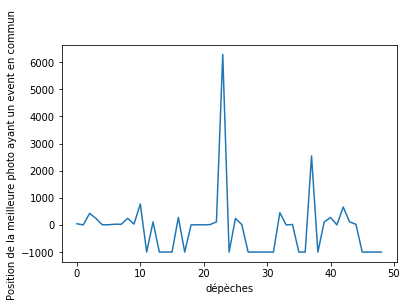

In [26]:
plt.xlabel("dépèches")  
plt.ylabel("Position de la meilleure photo ayant un event en commun ")
plt.plot(range(len(P)),P)  
plt.show()
    


In [27]:
print("Nombre perfect match" , c1, "\n <=5", c2 , " \n <=10", c3 , " sur 50 photos" )

Nombre perfect match 2 
 <=5 5  
 <=10 8  sur 50 photos


In [28]:
%%time
import matplotlib.pyplot as plt

for k in tqdm_notebook(index_inter[50:150]):
    liste_event_commun = event_commun(k)
    L = best_images(k,True)
   
    if  L != [] :
        if L[0][1] in liste_event_commun:
                c1+=1
        position = -1000
        j=0
        while position == -1000 and j<len(L):

            if L[j][1] in liste_event_commun:
                position = j + 1
                score_com = L[j][0]

            j+=1
        if position<=5 and position != -1000: 
            c2+=1
        if position<=10 and position != -1000:
            c3+=1
        P.append(position)

        

/Users/ya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


UnboundLocalError: local variable 'm' referenced before assignment

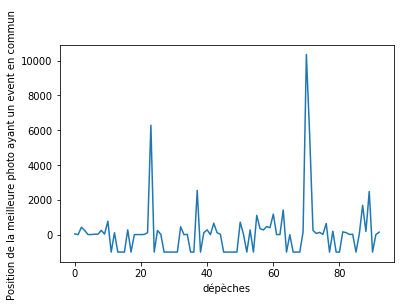

In [29]:
plt.xlabel("dépèches")  
plt.ylabel("Position de la meilleure photo ayant un event en commun ")
plt.plot(range(len(P)),P)  
plt.show()
    

In [30]:
print("Nombre perfect match" , c1, "\n <=5", c2 , " \n <=10", c3 , " sur 150 photos" )

Nombre perfect match 3 
 <=5 8  
 <=10 13  sur 150 photos
